In [1]:
def cleaning(df):
    import re
    import string

    def clean(text):
        text = str(text)
        text = text.lower()
        text = re.sub("@[A-Za-z0-9_]+", "", text)  # Menghapus @<name> [mention twitter]
        text = re.sub("#\w+", "", text)
        text = re.sub("\[.*?\]", "", text)
        text = re.sub("https?://\S+|www\.\S+", "", text)
        text = re.sub("<.*?>+", "", text)
        text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
        # text = re.sub('\n', '', text)
        text = re.sub("\w*\d\w*", "", text)
        text = re.sub("\d+", "", text)
        text = re.sub("\s+", " ", text).strip()
        # text = re.sub('\n', '', text) jadi:
        text = text.replace("\n", " ")
        text = " ".join(text.split())
        return text

    # Applying the cleaning function
    df['tweet2'] = df['Tweet'].apply(lambda x: clean(x))
    df.head()
    
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    import swifter

    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    df['cleaned'] = df['tweet2'].swifter.apply(lambda x: stemmer.stem(x))
    
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

    factory = StopWordRemoverFactory()

    stopword = factory.get_stop_words()
    stopwords = factory.create_stop_word_remover()

    df['cleaned'] = df['cleaned'].apply(lambda x: stopwords.remove(x))

    from nltk import word_tokenize
    from nltk.corpus import stopwords

    new_stopwords = ['sahabat', 'nomor','yg','jd','klo','pa','bpj','nya','tp','ga','jg','https','co','aja','ya',
                    'gw','kalo','tuh','tau','gk','gak','kalo','amp','gitu','krn','dr','sih','gue','bgt', 'aja','ya','krn','pake','udah','sampe','udah','emang','nggak','gk','udh','kela','bpjskesehatanri','duanya','banget','tdk', 'bpjsmelayani','gotongroyongsemuatertolong','gotongroyongsemuatertolong_jknhadiruntukrakyat','bpjskesehatan_bpjsmelayani'
                    ,'dgn','nih','loh','dpt','yaa','dah','kak','sm','ngga','dg','deh','lho','utk','kali', 'a', 'b',
                    'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v','w','x','y','z', 'gua','sya', 'iya', 'ni']

    stop_words = stopwords.words('indonesian')
    stop_words.extend(new_stopwords)


    def removeStopword(str):
        stop_words = stopwords.words('indonesian')
        stop_words.extend(new_stopwords)
        # stop_words = set(stopwords.words('indonesian'))
        word_tokens = word_tokenize(str)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        return ' '.join(filtered_sentence)

    df['cleaned'] = df['cleaned'].apply(lambda x: removeStopword(x))
    
    return df

In [2]:

def load_model_predict(df):
    sentences = df['cleaned'].tolist()
    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from keras.preprocessing.text import Tokenizer

    # The maximum number of words to be used. (most frequent)
    MAX_NB_WORDS = 1000
    # Max number of words in each complaint.
    MAX_SEQUENCE_LENGTH = 50
    # This is fixed.
    EMBEDDING_DIM = 16

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['Tweet'].values)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = tokenizer.texts_to_sequences(df['Tweet'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    
    from tensorflow.keras.models import model_from_json

    # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")
    
    # evaluate loaded model on test data
    loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    y_pred = loaded_model.predict(X)
    
    df['Sentiment'] = np.NaN
    for i in range(len(y_pred)):
        df['Sentiment'][i] = np.argmax(y_pred[i])
    
    return df

In [3]:
import numpy as np

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


In [5]:
df = pd.read_csv('garuda.csv')
df

NameError: name 'pd' is not defined

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Found 862 unique tokens.
Shape of data tensor: (101, 50)
Loaded model from disk
4/4 [==============================] - 2s 14ms/step


C:\Users\Aldo\AppData\Local\Temp\ipykernel_17784\3699063481.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'][i] = np.argmax(y_pred[i])


In [ ]:
df

,User,Tweet ID,Date Created,Number of Likes,Source of Tweet,Tweet,tweet2,cleaned,Sentiment
0,critaharian,1601003037434081281,2022-12-08 23:57:23+00:00,0,Rekomendasi Produk,✨ garuda ting ting permen kacang(1 sax isi 50p...,✨ garuda ting ting permen sax isi ✨ rating cek...,garuda ting ting permen sax isi rating cek harga,0.0
1,garuda080,1601002304790204416,2022-12-08 23:54:29+00:00,18,Twitter for Android,"Saat ini kasus Covid-19 di Jatim naik lagi, Wa...",saat ini kasus di jatim naik lagi warga dimint...,jatim warga jaga prokes pakai masker jaga jara...,0.0
2,idbcpr,1601001908721680384,2022-12-08 23:52:54+00:00,0,Awtoshare,Jadwal Penerbangan Garuda Indonesia Terbaru - ...,jadwal penerbangan garuda indonesia terbaru,jadwal terbang garuda indonesia,1.0
3,owwakkamilin,1601001417371967489,2022-12-08 23:50:57+00:00,0,Twitter for Android,@garistengah_id Yang jadi pertanyaan gua selam...,yang jadi pertanyaan gua selama ini kenapa lam...,lambang garuda jersey timnas logo pssi perhati...,0.0
4,Sembara2024oke,1600997909524545537,2022-12-08 23:37:01+00:00,10,Twitter for Android,@TeddGus Partai Garuda gak punya sayap..lebih ...,partai garuda gak punya sayaplebih mirip parta...,partai garuda sayaplebih partai,1.0
...,...,...,...,...,...,...,...,...,...
96,ryxxfa,1600876462470750209,2022-12-08 15:34:26+00:00,0,Twitter for iPhone,@matchaddict Tissue 1kg. Rinso 4.5L.Minyak 4.5...,tissue rinso liter sunlight pepsodent taro kac...,tissue rinso liter sunlight pepsodent taro kac...,1.0
97,Umar13531013,1600875344055406594,2022-12-08 15:29:59+00:00,0,Twitter for Android,"@geloraco Kehendak Rakyat,Garuda akan tetap te...",kehendak rakyatgaruda akan tetap terbang😁,rakyatgaruda terbang,1.0
98,AdhityaPerdana1,1600866890045587456,2022-12-08 14:56:23+00:00,2,Twitter for Android,"@Antakun10 @UyokBack @GarudaMerPut Itu dia, ka...",itu dia kadang gua agak kesel juga ama mereka ...,kadang kesel ama nama bawa bawa garuda pancasi...,0.0
99,sportstarsdotid,1600866798689169409,2022-12-08 14:56:02+00:00,1,Twitter for Android,Negara dengan skuad termahal di Piala AFF 2022...,negara dengan skuad termahal di piala aff skua...,negara skuad mahal piala aff skuad garuda temb...,0.0


In [6]:
df[0]

NameError: name 'df' is not defined

In [7]:
df[0][np.argmax(df[0])]

NameError: name 'df' is not defined

In [8]:
df.Sentiment.value_counts()

NameError: name 'df' is not defined

In [10]:
import pandas as pd

In [11]:
def scraping(maskapai):
    from datetime import date
    from dateutil.relativedelta import relativedelta
    import snscrape.modules.twitter as sntwitter

    # Creating list to append tweet data to


    attributes_container = []

    # Using TwitterS earchScraper to scrape data and append tweets to list
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{maskapai} since:{date.today() + relativedelta(months=-2)} until:{date.today()} lang:id').get_items()): #big mouth:2022-08-05 until:2022-09-06
        if i>100:
            break
        attributes_container.append([tweet.user.username,tweet.id, tweet.date, tweet.likeCount, tweet.sourceLabel, tweet.content])
        
    # Creating a dataframe to load the list

    tweet = pd.DataFrame(attributes_container, columns=["User", "Tweet ID" ,"Date Created", "Number of Likes", "Source of Tweet", "Tweet"])
    
    tweet.to_csv(f'{maskapai}.csv', index=False)
    
    return tweet

In [39]:
df = scraping("garuda indonesia")

In [40]:
df = load_model_predict(cleaning(df))

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Found 950 unique tokens.
Shape of data tensor: (101, 50)
Loaded model from disk
4/4 [==============================] - 1s 8ms/step


C:\Users\Aldo\AppData\Local\Temp\ipykernel_22052\3699063481.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'][i] = np.argmax(y_pred[i])


In [18]:
def wordcloud(df, sentimen):
    if sentimen == 'positif':
       df = df[(df['Sentiment'] == 2.0)]
    elif sentimen == 'negatif':
        df = df[(df['Sentiment'] == 0.0)]
    else:
        df = df[(df['Sentiment'] == 1.0)]
    
    # Import the wordcloud library
    from wordcloud import WordCloud
    # Join the different processed titles together.
    long_string = ','.join(map(str, list(df['cleaned'].values)))
    # Create a WordCloud object
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            random_state=1,
            background_color="salmon",
            colormap="Pastel1",
            collocations=False,
            ).generate(long_string)

    # Visualize the word cloud
    return word_cloud.to_image()   

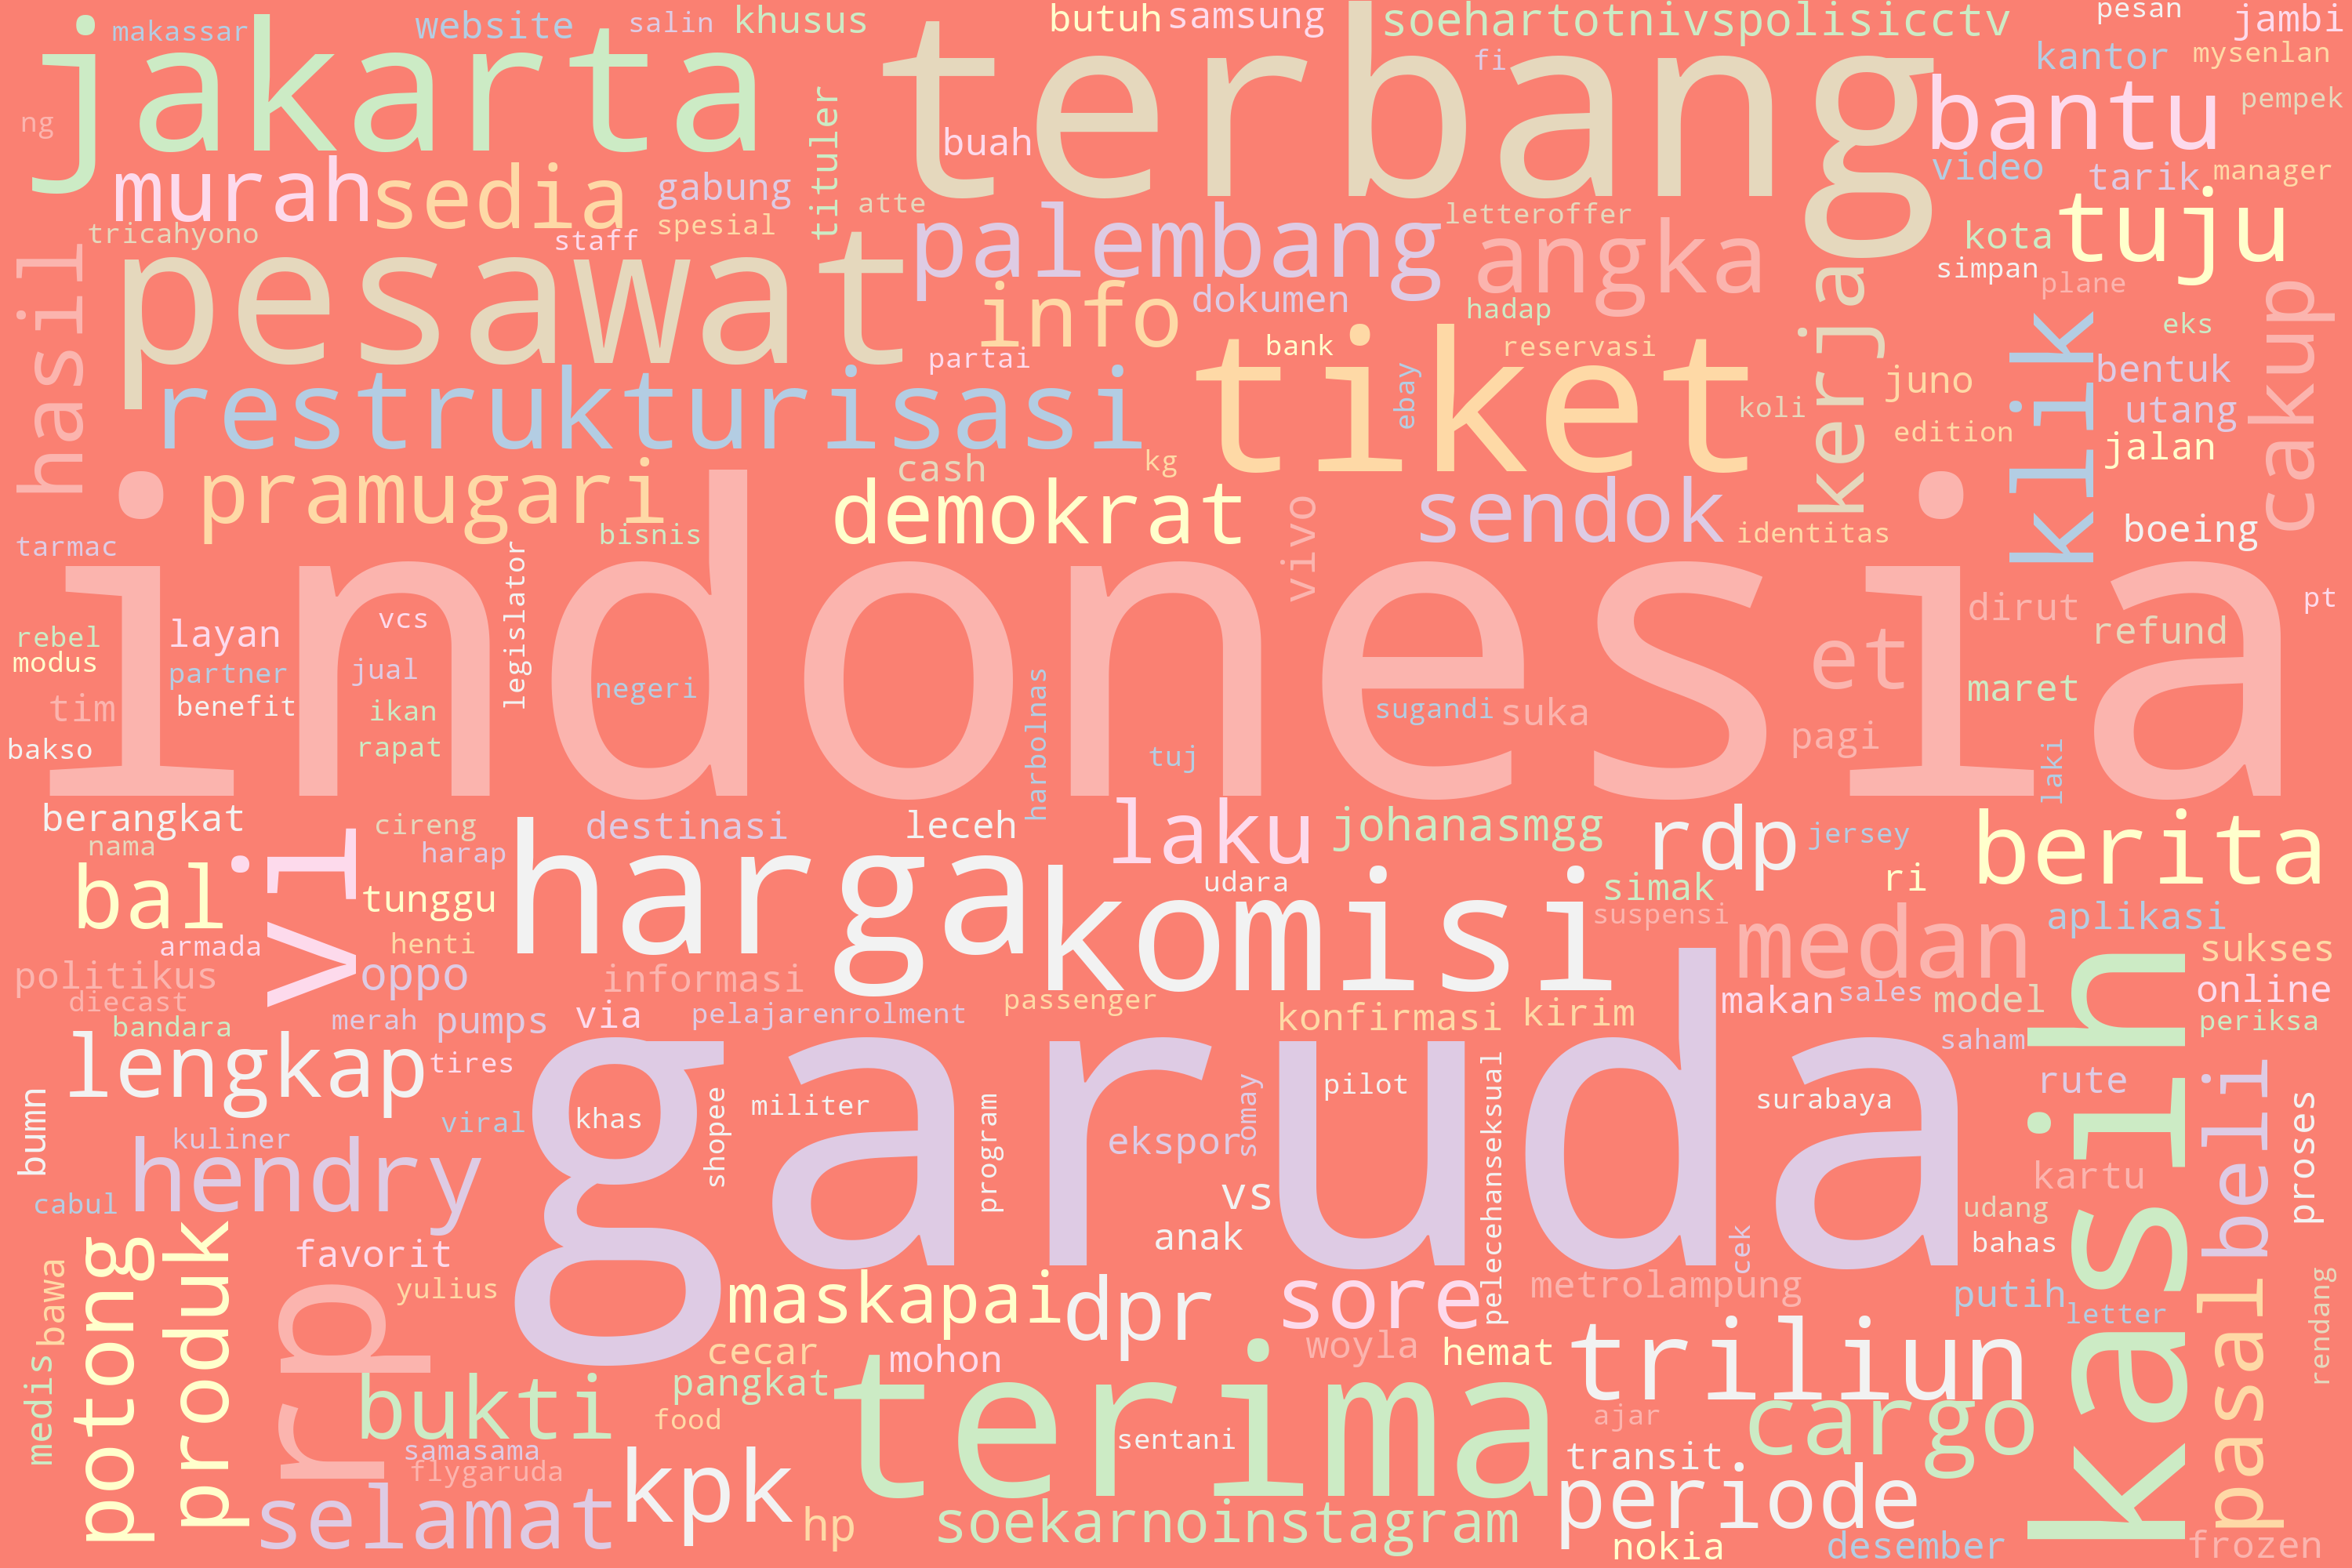

In [22]:
wordcloud(df, 'negatif')

In [47]:
def lda_predict(df, sentimen):
    from gensim.models.coherencemodel import CoherenceModel
    from gensim.models.ldamodel import LdaModel
    from gensim.corpora.dictionary import Dictionary
    from gensim import  models
    if sentimen == 'positif':
       lda = models.ldamodel.LdaModel.load('poslda_model')
       df = df[(df['Sentiment'] == 2.0)]
    elif sentimen == 'negatif':
        lda = models.ldamodel.LdaModel.load('lda_model')
        df = df[(df['Sentiment'] == 0.0)]
    else:
        lda = models.ldamodel.LdaModel.load('netlda_model')
        df = df[(df['Sentiment'] == 1.0)]
        
    text = df.cleaned
    text_list =  [i.split() for i in text]

    
    from gensim import corpora

    dictionary = corpora.Dictionary(text_list)


    doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
   
    tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
    corpus_tfidf = tfidf[doc_term_matrix]
    
    model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=3) #num topic menyesuaikan hasil dari coherence value paling tinggi
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic)) 

    return model

In [48]:
lda_predict(df, "positif")

Topic: 0 Word: 0.068*"report" + 0.067*"trip" + 0.067*"crj" + 0.067*"flight" + 0.067*"jakarta" + 0.067*"bombardier" + 0.066*"bengkulu" + 0.034*"tarik" + 0.033*"destinasi" + 0.033*"domestik"
Topic: 1 Word: 0.071*"tarik" + 0.051*"nikmat" + 0.050*"partner" + 0.050*"bank" + 0.050*"desember" + 0.050*"agam" + 0.050*"it" + 0.050*"time" + 0.050*"tawar" + 0.050*"harbolnas"
Topic: 2 Word: 0.045*"bombardier" + 0.045*"bengkulu" + 0.044*"flight" + 0.044*"crj" + 0.044*"tarik" + 0.044*"jakarta" + 0.044*"trip" + 0.044*"internasional" + 0.043*"destinasi" + 0.043*"harbolnas"


In [13]:
import tensorflow as tf